In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import math
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import pprint

In [2]:
from datetime import datetime

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
csv_path = '/Users/pbadami/Documents/njtransit/csv'

In [6]:
csv_path = '/Users/pranav/Documents/development/njtransit/csv'

In [5]:
day = '2018_03_02'

In [6]:
day_df = pd.read_csv('{}/{}.csv'.format(csv_path, day))

In [7]:
def clean_delay(sec):
    if sec < 0:
        return 0
    else:
        return sec

# temporarily fix wrong day 
def fix_day(row):
    # wrong day
    if row['delay'] >= (1400*60):
        row['time'] = row['time'] - dt.timedelta(days=1)
        row['delay'] = (row['time'] - row['expected']).total_seconds()
    return row
        
def format_df(df):
    df['expected'] = pd.to_datetime(df['expected'])
    df['time'] = pd.to_datetime(df['time'])

    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df = df.apply(fix_day, axis=1)
    df['delay'] = df['delay'].apply(lambda x: clean_delay(x))/60.0 # clean delay and get delay in minutes
    df['status'] = df['status'].fillna("Estimated")
    return df

In [8]:
df = format_df(day_df)

In [9]:
trains = df.groupby(['train_id', 'date'])

In [10]:
trains_last = trains.last()
trains_first = trains.nth(1)

In [11]:
trains_last['day_of_week'] = trains_last['time'].dt.dayofweek
trains_first['day_of_week'] = trains_first['time'].dt.dayofweek

In [12]:
trains_last['hour'] = trains_last['time'].dt.hour
trains_last['sched_hour'] = trains_last['expected'].dt.hour

trains_first['hour'] = trains_first['time'].dt.hour
trains_first['sched_hour'] = trains_first['expected'].dt.hour

In [13]:
trains_last = trains_last[trains_last['type'] == 'NJ Transit'].copy()
trains_first = trains_first[trains_first['type'] == 'NJ Transit'].copy()

In [14]:
def get_severity(row):
    delay = row['delay']
    status = row['status']
    if status == 'Cancelled':
        return "Cancelled"
    if math.isnan(delay):
        return "Unscheduled"
    if 0 <= delay < 3:
        return "On time"
    if 3 <= delay < 6:
        return "3-5 min"
    if 6 <= delay < 10:
        return "6-9 min"
    if 10 <= delay < 20:
        return "10-20 min"
    return "20+ min"

In [15]:
trains_last['severity'] = trains_last.apply(get_severity, axis=1)
trains_first['severity'] = trains_first.apply(get_severity, axis=1)

In [16]:
trains_last.reset_index(level='date', inplace=True)
trains_first.reset_index(level='date', inplace=True)

In [17]:
# turn into dict
colors={'On time': '#39e600', 
        '3-5 min': '#ffff00', 
        '6-9 min': '#ff9933', 
        '10-20 min': '#ff0000', 
        '20+ min': '#990000', 
        'Cancelled': '#827e7d'}
colors_list= ['#39e600', '#ffff00', '#ff9933', '#ff0000', '#990000', '#827e7d']

In [18]:
len(trains_last)

779

In [19]:
len(trains_first)

779

In [20]:
to_nyp = trains_last[trains_last['to'] == "New York Penn Station"].copy()
from_nyp = trains_first[(trains_first['from'] == "New York Penn Station") & (trains_first['severity'] != 'Unscheduled')].copy()

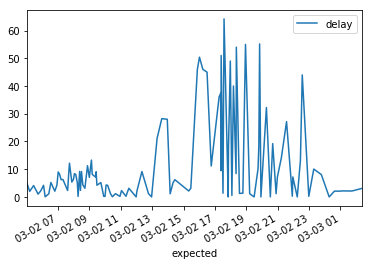

In [21]:
df[(df['from']=='Newark Penn Station') & (df['to']=='Secaucus Upper Lvl')].plot(x='expected', y='delay')

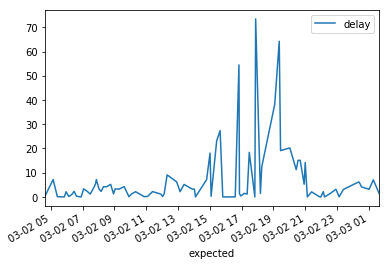

In [22]:
df[(df['from']=='Secaucus Upper Lvl') & (df['to']=='Newark Penn Station')].plot(x='expected', y='delay')

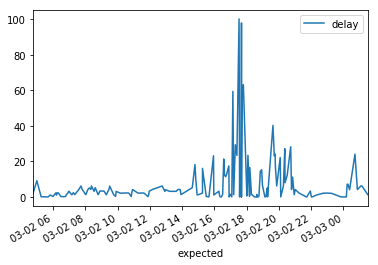

In [23]:
from_nyp.plot(x='expected', y='delay')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e76acd0>]], dtype=object)

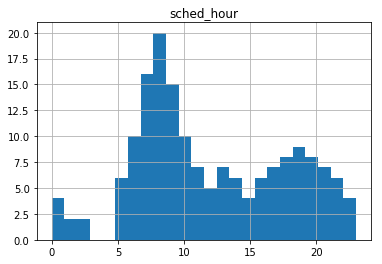

In [24]:
to_nyp.hist('sched_hour', bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fd935d0>]], dtype=object)

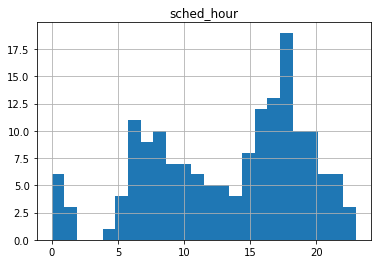

In [25]:
from_nyp.hist('sched_hour', bins=24)

In [26]:
test = to_nyp.copy()
test2 = from_nyp.copy()

In [27]:
test['sequence'] = test.sort_values('time').groupby('sched_hour').cumcount() + 1
test2['sequence'] = test2.sort_values('time').groupby('sched_hour').cumcount() + 1

In [28]:
test['severity_color'] = test['severity'].map(colors)
test2['severity_color'] = test2['severity'].map(colors)

In [29]:
test['id'] = test.index
test2['id'] = test2.index

In [30]:
df[df['train_id'] == '3943']

,train_id,date,stop_sequence,from,from_id,to,to_id,expected,time,status,line,type,delay
3323,3943,2018-03-02,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 16:13:00,2018-03-02 16:21:19,Cancelled,Northeast Corrdr,NJ Transit,8.316667
3324,3943,2018-03-02,2.0,New York Penn Station,105,Secaucus Upper Lvl,38187,2018-03-02 16:22:00,2018-03-02 16:21:19,Cancelled,Northeast Corrdr,NJ Transit,0.000000
3325,3943,2018-03-02,3.0,Secaucus Upper Lvl,38187,Newark Penn Station,107,2018-03-02 16:32:00,2018-03-02 16:21:19,Cancelled,Northeast Corrdr,NJ Transit,0.000000
3326,3943,2018-03-02,4.0,Newark Penn Station,107,Princeton Junction,125,2018-03-02 17:09:00,2018-03-02 16:21:19,Cancelled,Northeast Corrdr,NJ Transit,0.000000
3327,3943,2018-03-02,5.0,Princeton Junction,125,Hamilton,32905,2018-03-02 17:18:00,2018-03-02 16:21:19,Cancelled,Northeast Corrdr,NJ Transit,0.000000
3328,3943,2018-03-02,6.0,Hamilton,32905,Trenton,148,2018-03-02 17:26:00,2018-03-02 16:21:19,Cancelled,Northeast Corrdr,NJ Transit,0.000000


In [31]:
test2[test2['id'] == '3275']

,date,delay,expected,from,from_id,line,status,stop_sequence,time,to,to_id,type,day_of_week,hour,sched_hour,severity,sequence,severity_color,id
train_id,,,,,,,,,,,,,,,,,,,
3275,2018-03-02,1.383333,2018-03-02 18:38:00,New York Penn Station,105,No Jersey Coast,Departed,2.0,2018-03-02 18:39:23,Secaucus Upper Lvl,38187,NJ Transit,4,18,18.0,On time,14,#39e600,3275


In [32]:
trace1 = go.Scatter(
    x = test['sched_hour'],
    y = test['sequence'],
    mode='markers',
    marker=dict(
        size='16',
        color = test['severity_color'], #set color equal to a variable
    ),
    text = test['line'] + test['id']
)
data = [trace1]
plotly.offline.iplot(data)


In [33]:
trace2 = go.Scatter(
    x = test2['sched_hour'],
    y = test2['sequence'],
    mode='markers',
    marker=dict(
        size='16',
        color = test2['severity_color'], #set color equal to a variable
    ),
    text= test2['line'] + test2['id']
)
data = [trace2]
plotly.offline.iplot(data)

In [34]:
relevant = ['New York Penn Station', 'Secaucus Upper Lvl', 'Newark Penn Station'] 

In [35]:
relevant_df = df[(df['from'].isin(relevant)) | (df['to'].isin(relevant))]

In [36]:
cutoff = datetime(2018,3,2,12)

In [37]:
len(relevant_df.groupby('train_id').size())

496

In [40]:
relevant_df = relevant_df[relevant_df['time'] >= cutoff].copy()

In [41]:
station_map = {'Newark Penn Station': 5,
               'Secaucus Upper Lvl': 10, 
               'New York Penn Station': 15}

In [42]:
relevant_df['from_x'] = relevant_df['from'].map(station_map)
relevant_df['to_x'] = relevant_df['to'].map(station_map)



In [43]:
relevant_df['from_x'].fillna(0, inplace=True)
relevant_df['to_x'].fillna(0, inplace=True)

In [84]:
def get_direction(group):
    from_x = group.iloc[0]['from_x']
    to_x = group.iloc[-1]['to_x']
    if from_x > to_x:
        group['direction'] = 0
    else:
        group['direction'] = 1
    print group.iloc[0]['train_id'], from_x, to_x, group.iloc[0]['direction']
    return group

In [85]:
relevant_df = relevant_df.sort_values('time').groupby('train_id').apply(get_direction)

2303 0.0 0.0 1
2303 0.0 0.0 1
2312 0.0 0.0 1
2313 0.0 0.0 1
2605 0.0 0.0 1
2607 0.0 0.0 1
2609 0.0 0.0 1
2611 0.0 0.0 1
3154 0.0 15.0 1
3165 15.0 0.0 0
3173 15.0 0.0 0
3177 15.0 0.0 0
3239 10.0 0.0 0
3240 0.0 15.0 1
3243 15.0 0.0 0
3244 0.0 15.0 1
3247 15.0 0.0 0
3248 0.0 15.0 1
3251 15.0 0.0 0
3252 0.0 15.0 1
3255 15.0 0.0 0
3256 0.0 15.0 1
3260 0.0 15.0 1
3266 0.0 15.0 1
3269 15.0 0.0 0
3270 0.0 15.0 1
3271 15.0 0.0 0
3272 0.0 15.0 1
3274 0.0 15.0 1
3275 15.0 0.0 0
3276 0.0 15.0 1
3278 0.0 15.0 1
3279 15.0 0.0 0
3281 15.0 0.0 0
3283 15.0 0.0 0
3284 0.0 15.0 1
3285 15.0 0.0 0
3288 0.0 15.0 1
3289 15.0 0.0 0
3292 0.0 15.0 1
3361 15.0 0.0 0
3363 15.0 0.0 0
3373 10.0 0.0 0
3509 15.0 0.0 0
3510 0.0 15.0 1
3511 15.0 0.0 0
3512 0.0 15.0 1
3513 15.0 0.0 0
3514 0.0 15.0 1
3515 5.0 0.0 0
3516 0.0 15.0 1
3595 15.0 10.0 0
3598 0.0 15.0 1
3719 15.0 0.0 0
3721 15.0 0.0 0
3723 15.0 15.0 1
3725 15.0 0.0 0
3727 15.0 0.0 0
3731 15.0 0.0 0
3737 15.0 15.0 1
3738 0.0 15.0 1
3742 10.0 10.0 1
3838 5.0 15.0

In [74]:
test_df = relevant_df.iloc[0:50]

In [87]:
test_df[test_df['train_id'] == 'A2117']

,train_id,date,stop_sequence,from,from_id,to,to_id,expected,time,status,line,type,delay,direction,from_x,to_x
501,A2117,2018-03-02,NaN,Newark Penn Station,107,Newark Penn Station,107,NaT,2018-03-02 12:16:11,Departed,ACELA EXPRESS,Amtrak,NaN,0,5.0,5.0
502,A2117,2018-03-02,NaN,Newark Penn Station,107,New York Penn Station,105,NaT,2018-03-02 12:26:04,Departed,ACELA EXPRESS,Amtrak,NaN,0,5.0,15.0
503,A2117,2018-03-02,NaN,New York Penn Station,105,Metropark,83,NaT,2018-03-02 12:31:08,Departed,ACELA EXPRESS,Amtrak,NaN,0,15.0,0.0


In [67]:
train_dict = {}
train_x = []
train_y = []
frames = []

for index, row in test_df.iterrows():
    position = (row['to_x'], row['direction'])
    if row['train_id'] not in train_dict:
        train_dict[row['train_id']] = {'idx': len(train_x),
                                       'positions': [position]}
        train_x.append(int(position[0]))
        train_y.append(position[1])
    else:
        train_dict[row['train_id']]['positions'].append(position)
        idx = train_dict[row['train_id']]['idx']
        train_x[idx] = int(position[0])
        train_y[idx] = position[1]
    frames.append({'data': [{'x': list(train_x), 'y': list(train_y)}]})

In [68]:
figure = {'data': [{'x': [0, 1], 'y': [0, 1], 'type': 'scatter', 'mode':'markers'}],
          'layout': {'xaxis': {'range': [0, 20], 'autorange': False},
                     'yaxis': {'range': [-1, 2], 'autorange': False},
                     'title': 'Start Title',
                     'updatemenus': [{'type': 'buttons',
                                      'buttons': [{'label': 'Play',
                                                   'method': 'animate',
                                                   'args': [None]}]}]
                    },
          'frames': frames
#           'frames': [{'data': [{'x': [1, 2], 'y': [1, 2]}]},
#                      {'data': [{'x': [1, 4], 'y': [1, 4]}]},
#                      {'data': [{'x': [3, 4], 'y': [3, 4]}],
#                       'layout': {'title': 'End Title'}}]
         }
plotly.offline.iplot(figure)